# Base punch out of QChip

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from HelpModule import *
from E5080B_driver import *
from SGS100A_driver import *
from spirack import SPI_rack, S4g_module
from IPython.display import clear_output
from time import sleep

twpa_on = False
vna = E5080B_driver('TCPIP0::192.168.0.235::inst0::INSTR')
vna.open()

if twpa_on:
    twpa = SGS100A_driver('TCPIP0::192.168.0.34::inst0::INSTR')
else:
    twpa = SGS100A_driver('dummy')

Could not connect to dummy


In [10]:
from datetime import datetime

params={}
params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')
params['test_type'] = 'punchout'

# Qubit Parameters
params['qubit_name'] = 'FSCO03'
params['qubit_power'] = -8
params['twpa_power'] = 0.0
params['twpa_frequency'] = 0.0
params['twpa_on'] = False
params['vna_power'] = -70 #Single Photon Regime
params['center_freq'] = 7.314504990e9 
params['span_freq'] = 70
params['flux_curr'] = 0
params['temp'] = 22.2
params['comment'] = "# 2QCRC3\n" +\
                    "# Qubit 01 " +\
                    "# " +\
                    "# " +\
                    "# \n"

params['vna_power_initial'] = 0
params['vna_power_final'] = -60
params['vna_power_step'] = -5

npoints = 1001

if params['twpa_on']:
    twpa.setup(params['twpa_frequency'], params['twpa_power'])

meas = 'S21'

Center frequency: 7314084990.00 Hz
Quality Factor: 1661.496


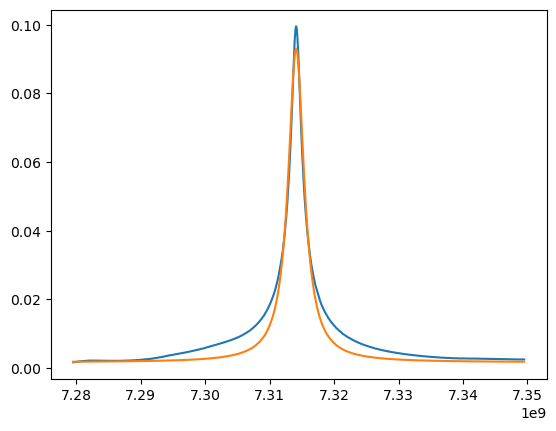

In [6]:
# from importlib import reload
# import HelpModule as help
# reload(help)
# Get high power pectrum

freqs, mag ,phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = params['span_freq'], power = 0, sleep_t = 3, npoints = 1001, data_format = 'MA', meas = meas, overule_power=True)
f_c_hp, Qf, fwhm = Q(freqs,mag, True)

#f_c_hp, Qf, fwhm = Q(freqs,mag.max()-mag, True)
print('Center frequency: %2.2f Hz'%f_c_hp)
print('Quality Factor: %2.3f'%Qf) 


Center frequency: 7332844990.00 Hz
Quality Factor: 1759.040


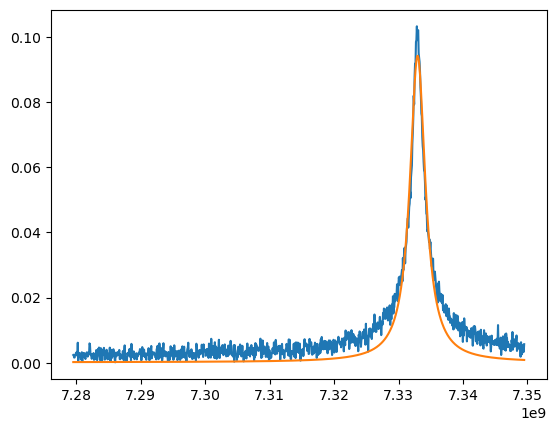

In [4]:
# from importlib import reload
# import HelpModule as help
# reload(help)

# Get low power pectrum
with twpa:
        freqs, mag,phase = meas_spectrum(vna, f_c = params['center_freq'], f_span = params['span_freq'], power = -50, sleep_t = 10, npoints = 1001, data_format = 'MA',meas = meas)

#Caculate the quality factor
f_c_lp, Qf, fwhm = Q(freqs, mag, True)

print('Center frequency: %2.2f Hz'%f_c_lp)
print('Quality Factor: %2.3f'%Qf)


#plt.plot(freqs*1e-9,mag)

Punch out frequency shift: 18.77 MHz


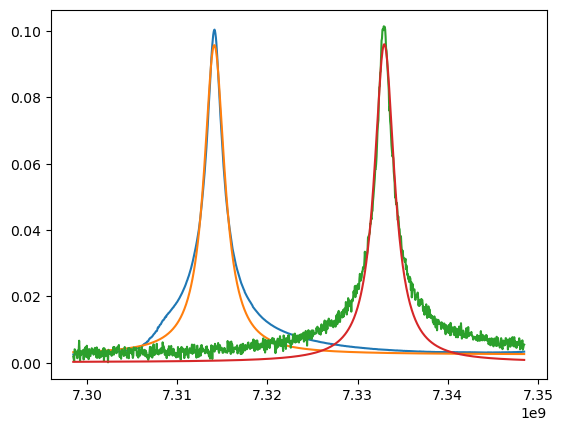

In [9]:
f_cm = (f_c_hp+ f_c_lp)/2

if params['twpa_on']:
    df = f_c_hp-f_c_lp
else:
    df = punch_out(vna, f_cm, hp=-5, lp=-50, f_span =50, meas=meas, overule_power=True)

print('Punch out frequency shift: %2.2f MHz'%(df*1e-6))

## Run a power sweep

In [11]:
#typename = params['test_type']

#Read parameters from the params dictionary
vna_power_initial = params['vna_power_initial']
vna_power_final = params['vna_power_final']
vna_power_step = params['vna_power_step']
#params['span_freq'] = 2

powersweep_array = np.arange(vna_power_initial,vna_power_final,vna_power_step)

vna.set_sweep_npoints(npoints)
vna.set_center_frequency(f_cm)
vna.set_span_frequency(params['span_freq'])
sleep(0.5)
freqs = vna.get_freq_array()
vna.set_power(params['vna_power'],overule_power=True)

delays = np.ndarray(len(powersweep_array))
mags = np.ndarray((len(powersweep_array),npoints))
phases = np.ndarray((len(powersweep_array),npoints))
Z = np.ndarray((len(powersweep_array),npoints),dtype=complex)

mags[:] = 0
phases[:] = 0
Z[:] = 0

delays[:] = np.round(np.logspace(np.log10(2),np.log10(10),num=len(delays), base=10),2)

time = np.sum(delays)+1*len(delays)
print('Estimated time is %2.2f min'%(time/60))


Estimated time is 1.21 min


idx=11, delay=10


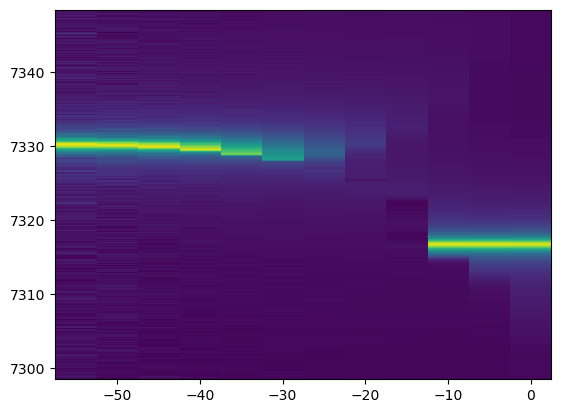

file saved as punchout_FSCO03_20240509_1145


In [12]:
vna.set_power(powersweep_array[0],overule_power=True)
vna.start_rf()

sleep(1)

try:
    with twpa:
        for idx,power in enumerate(powersweep_array):
            clear_output(wait=True)
            vna.set_power(power,overule_power=True)

            #sleep(0.05)

            vna.reset_average()
            delay = max(delays[idx], 0.3)
            sleep(delay)
            mag, phase =  vna.get_data(meas = meas)
                
            while mag.min()< -199.9:
                print('Error in the readout')
                sleep(delay)
                mag, phase =  vna.get_data()
    
            mags[idx] = mag
            phases[idx] = phase    
            
            #if (idx)%2 == 0:
            print('idx=%i, delay=%i'%(idx,delay))
            plt.pcolor(powersweep_array,freqs*1e-6,mags.T)
            plt.show()
except KeyboardInterrupt:
    print("Stopped")
finally:
    vna.stop_rf()
    params['test_date'] = datetime.today().strftime('%Y%m%d_%H%M')

    # always save_ even on errors
    header_str = get_plot_str(params)
    filename = params['test_type'] +"_"+params['qubit_name'] + "_" +params['test_date']
    np.savez("./data/"+filename,
            header = header_str,
            freqs=freqs,
            mags=mags,
            phases=phases,
            power=powersweep_array)
    print('file saved as %s'%filename)
        
Z = toComplex(mags,phases)



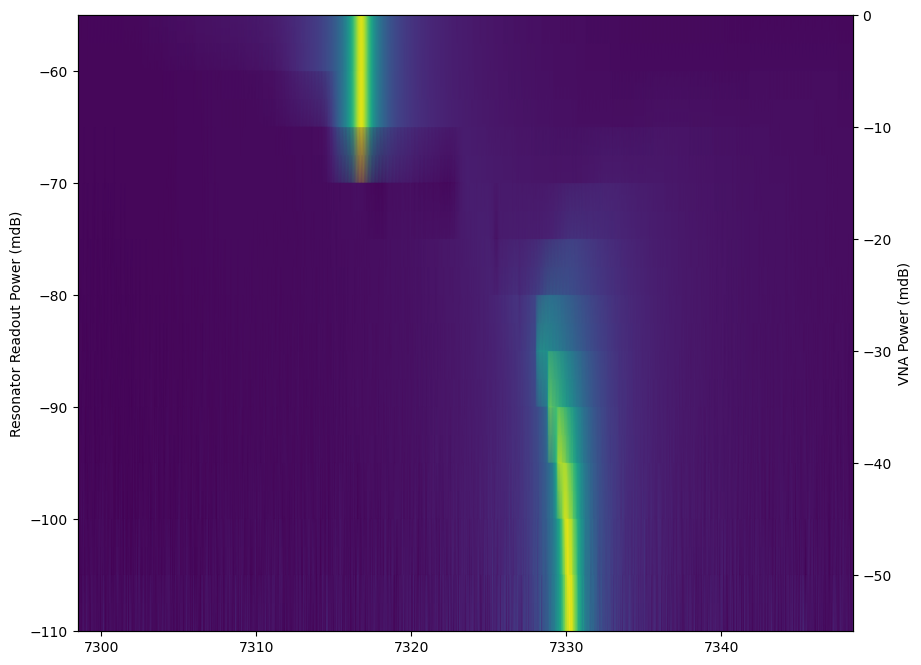

In [13]:
att = 55

#fig = plt.figure(figsize=( 12, 6))
fig, ax1 = plt.subplots()
fig.set_size_inches(10,8)

ax1.pcolormesh(freqs*1e-6,powersweep_array-att,(mags), 
            cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())
plt.ylabel('Resonator Readout Power (mdB)')


ax2 = ax1.twinx()
ax2.pcolormesh(freqs*1e-6,powersweep_array,(mags), 
            cmap='viridis', shading='gouraud', vmin=mags.min(), vmax=mags.max())

plt.xlabel('Frequency (MHz)')
plt.ylabel('VNA Power (mdB)')
plt.show()